# 전복 나이 예측 경진대회

In [237]:
import pandas as pd
import numpy as np

In [238]:
from sklearn.preprocessing import OneHotEncoder as oh

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from pycaret.regression import *

In [239]:
from imblearn.over_sampling import SMOTE

In [240]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train=train.drop(['id'], axis=1)

test=test.drop(['id'], axis=1)

display(train.shape, test.shape)

print(train.info())

#껍질을 제외한 무게라면 전체무게에서 껍질무게 뺴면 껍질을 제외한 무게가 나와야 하는데 맞지 않음

(1253, 9)

(2924, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          1253 non-null   object 
 1   Lenght          1253 non-null   float64
 2   Diameter        1253 non-null   float64
 3   Height          1253 non-null   float64
 4   Whole Weight    1253 non-null   float64
 5   Shucked Weight  1253 non-null   float64
 6   Viscra Weight   1253 non-null   float64
 7   Shell Weight    1253 non-null   float64
 8   Target          1253 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 88.2+ KB
None


# target의 분포를 보고 over sampling이 필요한지 고찰

In [37]:
target_df=pd.DataFrame(train['Target'].value_counts()).reset_index().sort_values('index')

In [43]:
target_df.columns

Index(['target', 'freq'], dtype='object')

# cumulative 값 구하는 방법

In [149]:
def sum_(x):
    return sum(x)


target_df['freq_cum'] = target_df['freq'].expanding().apply(sum_)

In [42]:
target_df.rename(columns = {"index":"target"}, inplace = True)
target_df.rename(columns = {"Target":"freq"}, inplace = True)

In [159]:
target_df['freq'].sum()

1253

In [162]:
target_df['freq_cum']=target_df['freq_cum'].apply(lambda x:x/target_df['freq'].sum()*100)

In [164]:
target_df

,target,freq,freq_cum
17,3,5,0.399042
12,4,14,1.516361
9,5,37,4.469274
5,6,88,11.492418
4,7,107,20.031923
2,8,174,33.918595
1,9,200,49.880287
0,10,202,66.001596
3,11,141,77.254589
6,12,79,83.559457


# target bar chart 시각화

<BarContainer object of 22 artists>

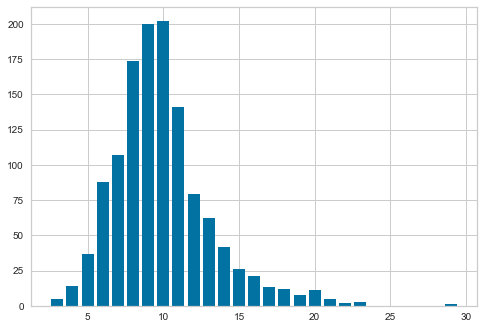

In [156]:
import matplotlib.pyplot as plt
plt.bar(target_df['target'], target_df['freq'])

# 누적 target 값 시각화

<BarContainer object of 22 artists>

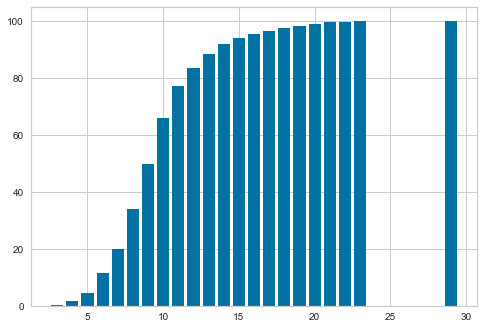

In [163]:
plt.bar(target_df['target'], target_df['freq_cum'])
# plt.show()

In [263]:
#분포를 확인하여 어디서  SMOTE를 시킬지를 정함 (50%)로 설정해봄 

# over sampling 시작

In [241]:
train=train[train['Target']<25]

In [242]:
train['Target_id']= np.where(train['Target']>9, 2, 1)

In [243]:
train=pd.get_dummies(train)

In [244]:
test=pd.get_dummies(test)

In [245]:
x_train=train[train.columns.difference(['Target_id'])]

In [246]:
y_train=train['Target_id']

In [247]:
x_train.head()

,Diameter,Gender_F,Gender_I,Gender_M,Height,Lenght,Shell Weight,Shucked Weight,Target,Viscra Weight,Whole Weight
0,0.470,0,0,1,0.115,0.605,0.3100,0.3925,15,0.2910,1.1140
1,0.315,0,1,0,0.095,0.430,0.1045,0.1750,8,0.0800,0.3780
2,0.490,0,1,0,0.195,0.580,0.4100,0.5305,18,0.2540,1.3165
3,0.405,0,0,1,0.175,0.535,0.3370,0.5480,13,0.3265,1.2705
4,0.235,0,1,0,0.090,0.310,0.0400,0.0480,6,0.0310,0.1270


In [248]:
x_train_over, y_train_over=sm.fit_sample(x_train, y_train)

In [249]:
y_train.value_counts()

2    627
1    625
Name: Target_id, dtype: int64

In [250]:
y_train_over.value_counts()

2    627
1    627
Name: Target_id, dtype: int64

In [251]:
train=pd.concat([x_train_over,y_train_over], axis =1)

In [252]:
train.columns

Index(['Diameter', 'Gender_F', 'Gender_I', 'Gender_M', 'Height', 'Lenght',
       'Shell Weight', 'Shucked Weight', 'Target', 'Viscra Weight',
       'Whole Weight', 'Target_id'],
      dtype='object')

In [253]:
train=train[train.columns.difference(['Target_id'])]

In [254]:
setup_clf = setup(data = train, target='Target', n_jobs = -1, remove_outliers=True)
#feature interaction이랑 outlier 추가해볼것  feature_interaction=True, 

,Description,Value
0,session_id,6904
1,Target,Target
2,Original Data,"(1254, 11)"
3,Missing Values,0
4,Numeric Features,10
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(833, 10)"


In [259]:
top5 = compare_models(sort='MAE', n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.5222,4.6013,2.1199,0.4984,0.1762,0.1497,0.0180
lr,Linear Regression,1.5469,4.5454,2.1117,0.5019,0.1773,0.1580,0.0140
lar,Least Angle Regression,1.5508,4.5556,2.1150,0.5004,0.1776,0.1585,0.0030
br,Bayesian Ridge,1.5513,4.5506,2.1138,0.5007,0.1778,0.1586,0.0030
rf,Random Forest Regressor,1.5536,4.6413,2.1447,0.4818,0.1782,0.1562,0.0650
gbr,Gradient Boosting Regressor,1.5553,4.6241,2.1380,0.4883,0.1771,0.1553,0.0240
et,Extra Trees Regressor,1.5879,4.8858,2.2032,0.4514,0.1833,0.1599,0.0410
ridge,Ridge Regression,1.5898,4.7658,2.1618,0.4789,0.1849,0.1618,0.0040
knn,K Neighbors Regressor,1.6403,5.3010,2.2821,0.4162,0.1910,0.1634,0.0040
lightgbm,Light Gradient Boosting Machine,1.6546,5.0055,2.2256,0.4385,0.1866,0.1659,0.0210


In [260]:
tuned_top5 = [tune_model(i) for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.2089,9.0081,3.0013,0.1844,0.2507,0.2257
1,2.3257,11.0043,3.3173,0.0975,0.2665,0.2245
2,1.7474,5.8004,2.4084,0.1671,0.2081,0.1806
3,1.8408,5.5839,2.3630,0.2535,0.2230,0.2107
4,1.9250,5.6964,2.3867,0.1325,0.2450,0.2523
5,2.2534,8.7325,2.9551,0.1847,0.2499,0.2323
6,1.7626,5.5432,2.3544,0.1932,0.2207,0.2144
7,2.2403,9.0497,3.0083,0.1691,0.2564,0.2380
8,2.1500,8.4103,2.9000,0.1261,0.2406,0.2113
9,1.9526,7.7751,2.7884,0.1317,0.2221,0.1855


In [261]:
stack_top5 = stack_models(estimator_list=tuned_top5,  choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.5837,4.7653,2.1830,0.5686,0.1762,0.1584
1,1.8125,6.9428,2.6349,0.4306,0.2015,0.1649
2,1.3737,3.8036,1.9503,0.4538,0.1605,0.1293
3,1.3799,3.0521,1.7470,0.5920,0.1627,0.1454
4,1.5312,4.0106,2.0026,0.3892,0.1812,0.1746
5,1.4430,3.8690,1.9670,0.6388,0.1695,0.1508
6,1.1625,2.3715,1.5400,0.6548,0.1442,0.1321
7,1.6189,4.8308,2.1979,0.5564,0.2327,0.1664
8,124.6461,21771.5691,147.5519,-2261.2072,2.3638,13.6372
9,1.5727,5.2529,2.2919,0.4133,0.1777,0.1450


In [262]:
blend_top5 = blend_models(estimator_list=tuned_top5,  choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.5508,4.7149,2.1714,0.5731,0.1747,0.1534
1,1.8559,7.3058,2.7029,0.4008,0.2071,0.1687
2,1.4073,3.9790,1.9947,0.4286,0.1652,0.1339
3,1.3650,3.1519,1.7754,0.5786,0.1597,0.1458
4,1.5198,3.6070,1.8992,0.4507,0.1779,0.1783
5,1.5192,4.3237,2.0794,0.5963,0.1738,0.1556
6,1.2379,2.5584,1.5995,0.6276,0.1491,0.1419
7,1.7085,5.2999,2.3022,0.5134,0.1932,0.1701
8,1.5980,4.9186,2.2178,0.4889,0.1787,0.1527
9,1.5844,5.4525,2.3351,0.3911,0.1809,0.1467


In [206]:
final_model_stack = finalize_model(stack_top5)

final_model_blend = finalize_model(blend_top5)

prediction_stack = predict_model(final_model_stack, data=test)
prediction_blend = predict_model(final_model_blend, data=test)

# return stack_top5, blend_top5, prediction_stack, prediction_blend

In [214]:
sample = pd.read_csv('data/sample_submission.csv')
# pd.DataFrame(predict_test)

# pd.DataFrame(sample['id'])

output=pd.concat([pd.DataFrame(sample['id']), pd.DataFrame(prediction_blend['Label'].round())],  axis = 1)

output.rename(columns = {'Label' : 'Target'}, inplace = True)
# 컬럼 이름 변경

output.to_csv('data/output_smote_blend.csv', index=False)